# Shapelet Discovery

This tutorial explores the "Shapelet Discovery" case study from the research paper: [The Swiss Army Knife of Time Series Data Mining: Ten Useful Things You Can Do with the Matrix Profile and Ten Lines of Code"](https://www.cs.ucr.edu/~eamonn/Top_Ten_Things_Matrix_Profile.pdf) (see Section 3.7). Also, you may want to refer to the [Matrix Profile I](https://www.cs.ucr.edu/~eamonn/PID4481997_extend_Matrix%20Profile_I.pdf) and [Time Series Shapelets: A New Primitive for Data Mining](https://www.cs.ucr.edu/~eamonn/shaplet.pdf) papers for more information and other related examples.

## What Is a Shapelet?


Informally, time series "shapelets" are time series subsequences which are, in some sense, maximally representative of a class. For example, imagine if you had a time series that tracked the electricity consumption being used every second by the large appliances within your home for five years. Each time you run your clothes dryer, dishwasher, or air conditioner, your power meter will record the electricity being consumed and just by looking at the time series you'll likely be able to associate an electricity consumption "signature" (i.e., shape, duration, maximum energy usage, etc) to each appliance. These patterns may be obvious or subtle and it is their uniquely "shaped" time series subsequence that allows you to differentiate between each appliance class. Thus, these so-called shapelets may be useful for classifying unlabeled time series that contain an occurrence of the shapelet. Don't worry if this sounds bit jargon-y as everything will hopefully become clearer through our example below. 

Recent research (see above) suggest that matrix profiles can be used to efficiently identify shapelets of a particular class and so, in this tutorial, we'll build on top of our matrix profile knowledge and demonstrate how we can use STUMPY to easily discover interesting shapelets in only a few lines of additional code.

## Getting Started

Let's import the packages that we'll need to load, analyze, and plot the data.

In [1]:
%matplotlib inline

import stumpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [20, 6]  # width, height
plt.rcParams['xtick.direction'] = 'out'

## Loading the GunPoint Dataset

This dataset is a motion capture time series that tracks the movement of an actors' right hand and contains two classes:

1. `Gun`
2. `Point`

In the `Gun` class, the actors draw a physical gun from a hip-mounted holster, point the gun at a target for approximately one second, then return the gun to the holster, and their hands to their sides. In the `Point` class,the actors leave their gun by their sides and, instead, they point their index fingers toward the target (i.e., without a gun) for approximately one second, and then return their hands to their sides. For both classes, the centroid of the actors' right hand was tracked to represent its motion.

Below, we'll retrieve the raw data, split them into the `gun_df` and the `point_df`, and then, for each respective class, concatenate all of the individual samples into one long time series. Additonally, we establish a clear boundary for each sample (i.e., where a sample starts and ends) by appending a `NaN` value after each sample. This helps to ensure that all matrix profile computations do not return artificial subsequences that span across multiple samples:

In [2]:
train_df = pd.read_csv("https://zenodo.org/record/4281349/files/gun_point_train_data.csv?download=1")

gun_df = train_df[train_df['0'] == 0].iloc[:, 1:].reset_index(drop=True)
gun_df = gun_df.assign(NaN=np.nan)
gun_df = gun_df.stack(dropna=False).to_frame().reset_index(drop=True)
gun_df = gun_df.rename({0: "Centroid Location"}, axis='columns')

point_df = train_df[train_df['0'] == 1].iloc[:, 1:].reset_index(drop=True)
point_df = point_df.assign(NaN=np.nan)
point_df = point_df.stack(dropna=False).to_frame().reset_index(drop=True)
point_df = point_df.rename({0: "Centroid Location"}, axis='columns')

## Visualizing the GunPoint Dataset

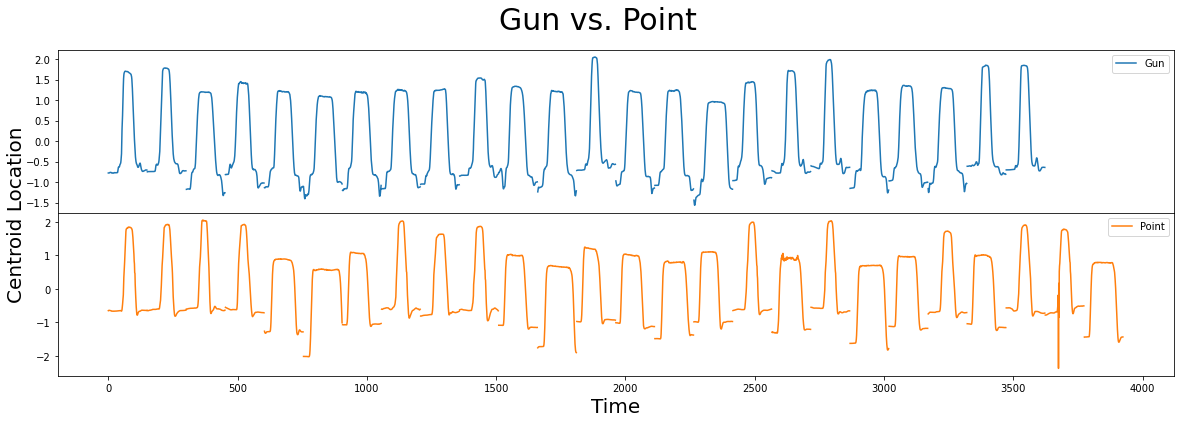

In [3]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Gun vs. Point', fontsize='30')
plt.xlabel('Time', fontsize ='20')
fig.text(0.09, 0.5, 'Centroid Location', va='center', rotation='vertical', fontsize='20')

axs[0].plot(gun_df, label="Gun")
axs[0].legend()

axs[1].plot(point_df, color="C1", label="Point")
axs[1].legend()
plt.show()

In this dataset, you'll see that there are 24 and 26 examples for the `gun_df` and `point_df`, respectively. Both classes contain narrow/wide samples and vertically shifted centroid locations that make it challenging to differentiate between them. Are you able to identify any subtle differences (i.e., shapelets) between `gun_df` and `point_df` that might help you distinguish between the two classes? 

It turns out that matrix profiles may be able useful in helping us automatically identify potential shapelets!

## Finding Candidate Shapelets With Matrix Profiles

Recall that the matrix profile gives us....

According to Section H of the [Matrix Profile I](https://www.cs.ucr.edu/~eamonn/PID4481997_extend_Matrix%20Profile_I.pdf) paper, the main intuition is that if a discriminitative pattern is present in the `Gun` class but not in the `Point` class, then we would expect to see

In [4]:
train_df = pd.read_csv("https://zenodo.org/record/4281349/files/gun_point_train_data.csv?download=1")
test_df = df = pd.read_csv("https://zenodo.org/record/4281349/files/gun_point_test_data.csv?download=1")

In [5]:
# Split train and test into features and target
X_train, y_train = train_df.iloc[:, 1:], train_df.iloc[:, 0]
X_test, y_test = test_df.iloc[:, 1:], test_df.iloc[:, 0]

In [6]:
# Split train into features and target (Gun and Point)
X_train_gun = train_df[train_df.iloc[:, 0] == 0.0].iloc[:, 1:]
X_train_point = train_df[train_df.iloc[:, 0] == 1.0].iloc[:, 1:]
y_train_gun = train_df[train_df.iloc[:, 0] == 0.0].iloc[:, 0]
y_train_point = train_df[train_df.iloc[:, 0] == 1.0].iloc[:, 0]

In [7]:
X_train_gun.shape, X_train_point.shape

((24, 150), (26, 150))

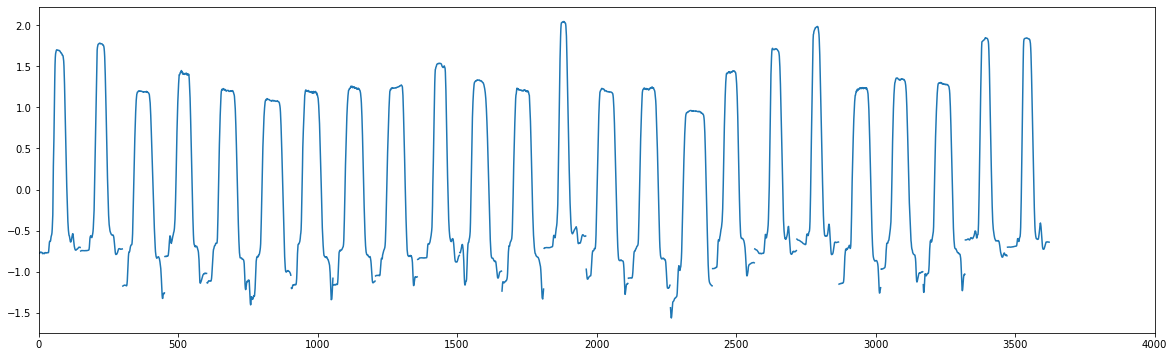

In [8]:
# construct and plot Gun timeseries (T_A)
X_train_gun = X_train_gun.assign(NaN=np.nan)  # add NaN values
T_A = X_train_gun.stack(dropna=False).to_frame().reset_index(drop=True)
plt.xlim(0, 4000)
plt.plot(T_A)
plt.show()

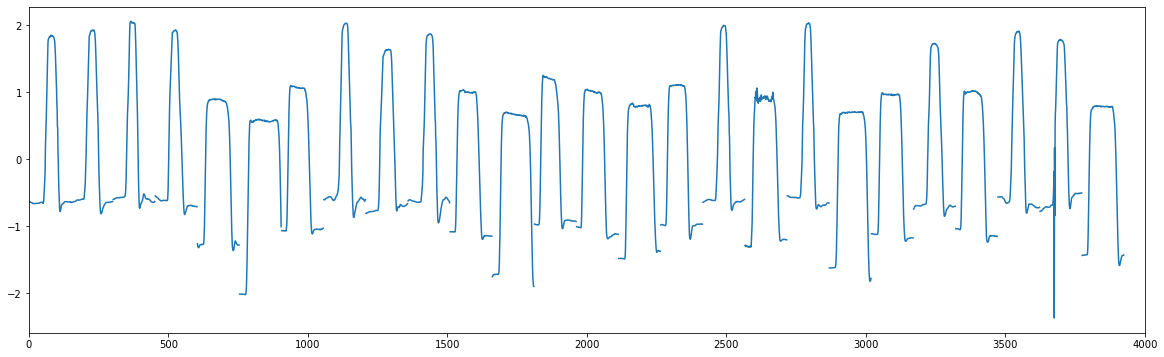

In [9]:
# construct and plot Point timeseries (T_B)
X_train_point = X_train_point.assign(NaN=np.nan)
T_B = X_train_point.stack(dropna=False).to_frame().reset_index(drop=True)
plt.xlim(0, 4000)
plt.plot(T_B)
plt.show()

## Matrix Profiles

We then compute two matrix profiles, $P_{BB}$ and $P_{BA}$. In the first matrix profiles, distances are calculated within the same timeseries ($T_{B}$), in the second case we are comparing subsequences from $T_{A}$ with those of $T_{B}$. For simplicity, we use a subsequence length of 38, which is the length of the best shapelet reported for this dataset by Ye and Keogh (2009) [2] 

In [10]:
m = 38
P_BB = stumpy.stump(T_B.iloc[:, 0], m).astype(np.float64)
P_BA = stumpy.stump(T_B.iloc[:, 0], m, T_A.iloc[:, 0], ignore_trivial=False).astype(np.float64)

Since we have some `np.nan` values in the our timeseries, the outputs of the Matrix profiles contain several `np.inf`values. We will manually correct this by changing them to `np.nan`

In [11]:
P_BB[P_BB == np.inf] = np.nan
P_BA[P_BA == np.inf] = np.nan

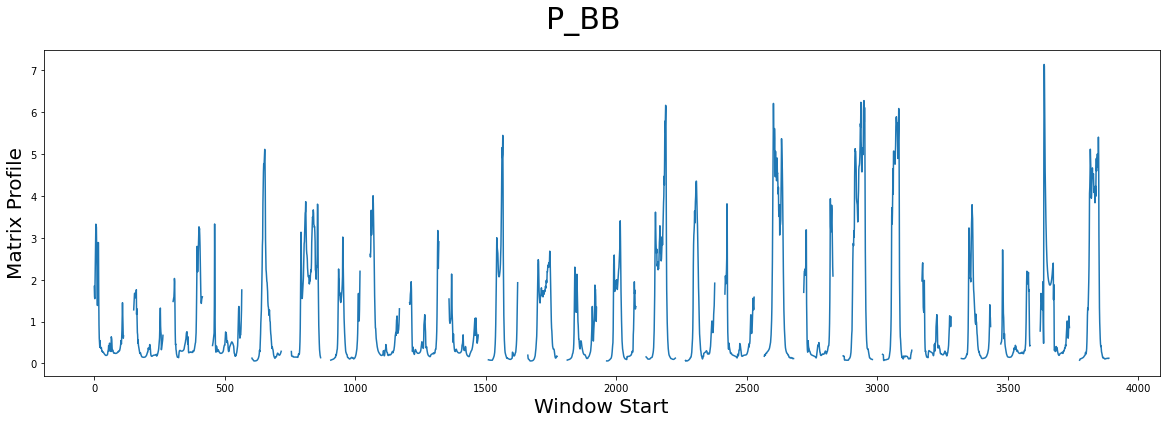

In [12]:
# Plot P_BB
plt.suptitle("P_BB", fontsize="30")
plt.xlabel("Window Start", fontsize="20")
plt.ylabel("Matrix Profile", fontsize="20")
plt.plot(P_BB[:, 0])
plt.show()

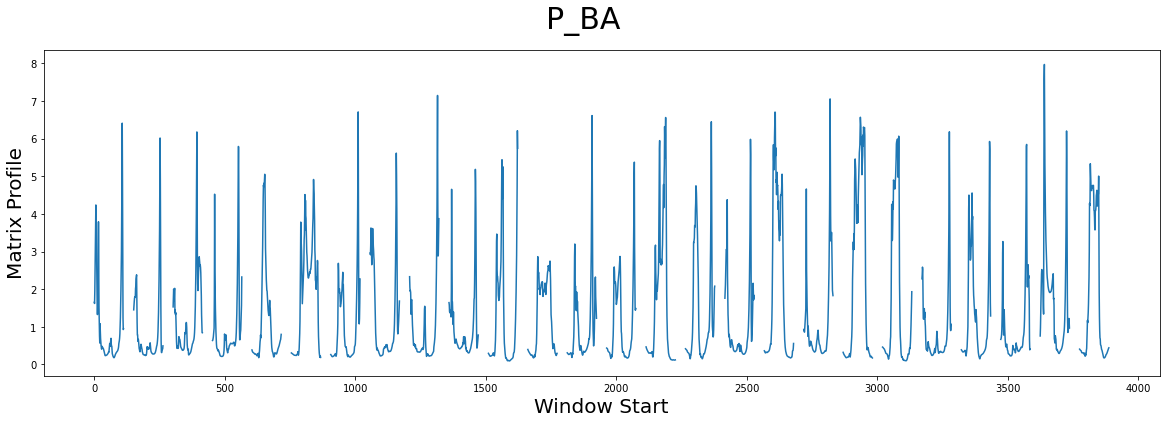

In [13]:
# plot P_BA
plt.suptitle("P_BA", fontsize="30")
plt.xlabel("Window Start", fontsize="20")
plt.ylabel("Matrix Profile", fontsize="20")
plt.plot(P_BA[:, 0])
plt.show()

We call $P$ The difference between $P_{BA}$ and $P_{BB}$. Intuitively, $P_{BB}$ will be smaller than $P_{BA}$ because we would expect subsequences within the same class to be more similar than those of different classes. 

The peak values in $P$ are indicators of good shapelet candidates, because they suggest patterns that are well conserved in their own class but are very different from their closest match in the other class.

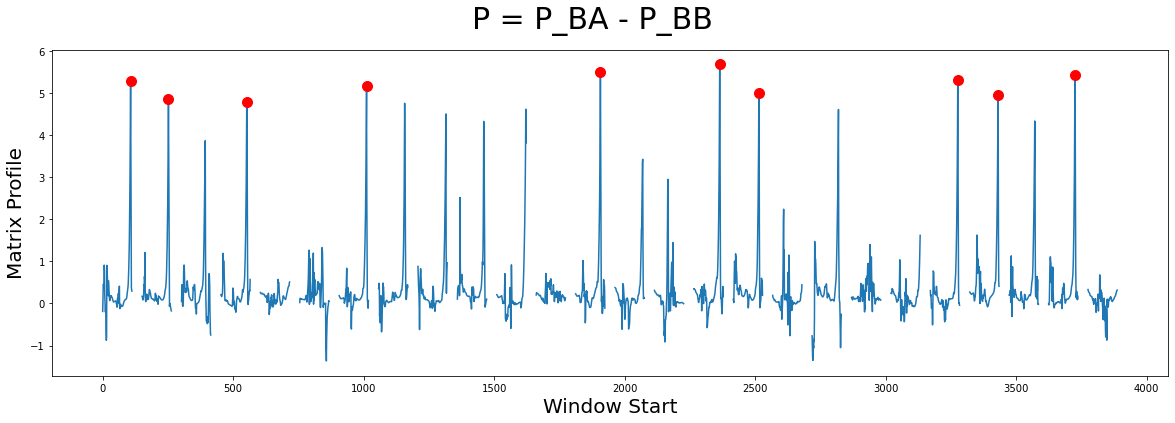

In [14]:
# subtract P_BB from P_BA
P = P_BA[:, 0] - P_BB[:, 0]
idx = np.argpartition(np.nan_to_num(P), -10)[
    -10:
]  # get the indexes of 10 peak values in P
plt.suptitle("P = P_BA - P_BB", fontsize="30")
plt.xlabel("Window Start", fontsize="20")
plt.ylabel("Matrix Profile", fontsize="20")
plt.plot(P)
plt.plot(
    idx, P[idx], color="red", marker="o", linewidth=0, markersize=10
)  # plot the indexes over P
plt.show()

## Shapelets and Classifier

Let's take a look at one of the shapelets that were identified through the matrix profile method.

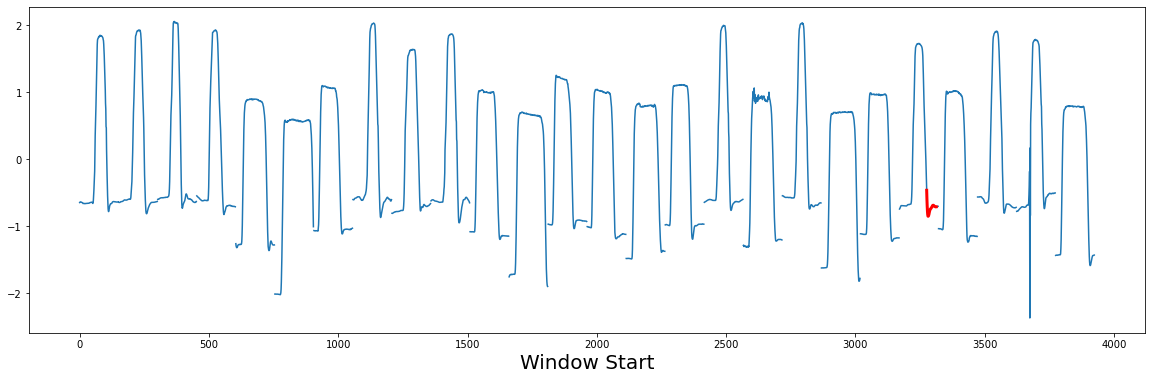

In [15]:
# Plot Shapelet
max_idx = np.random.choice(idx)
# max_idx = np.argwhere(P == np.nanmax(P)).flatten()[0]

plt.xlabel("Window Start", fontsize="20")
plt.plot(T_B.iloc[:, 0])
plt.plot(
    list(range(max_idx, (max_idx + m))),
    T_B.iloc[max_idx : (max_idx + m), 0],
    "r",
    linewidth=3.0,
)
plt.show()

Now that we have the indexes our Peak values we can use them to extract the values of shapelets candidates from the $T_{B}$ time series.

In [16]:
shapelets = []
for i in idx:
    shapelet = list(T_B.iloc[i : (i + m), 0])
    shapelets.append(shapelet)

Now, for our classification task, each shapelets needs to be evalued in terms of its predicitive power. Thus, we first calculate the distance profile (pairwise Euclidean distance) between a shapelet and every subsequence of a time-series. Then, the smallest value is kept to understand if a close match of the shapelet in the timeseries has been found. The `stumpy.core.mass` function does exactly so.

In [17]:
# Calculate distances from timeseries to extracted shapelets
def difference_matrix(X, shapelets):
    """Compute the distance beteen X, and the shapelets. Return a (len(X), len(shapelet)) distance matrix"""
    D = np.zeros((len(X), len(shapelets)))
    for s, shapelet in enumerate(shapelets):
        for i in range(len(X)):
            dist = stumpy.core.mass(shapelet, X.iloc[i, :])
            min_dist = dist.min()
            D[i, s] = min_dist
    return D

In [18]:
D_train_point = difference_matrix(X_train, shapelets)
D_test_point = difference_matrix(X_test, shapelets)

In [24]:
from sklearn import tree
from sklearn import metrics

for i in range(len(shapelets)):
    clf = tree.DecisionTreeClassifier()
    clf.fit(D_train_point[:, i].reshape(-1, 1), y_train)
    y_pred = clf.predict(D_test_point[:, i].reshape(-1, 1))
    print(f"Accuracy for shapelet {i} = {round(metrics.accuracy_score(y_test, y_pred), 3)}")

Accuracy for shapelet 0 = 0.867
Accuracy for shapelet 1 = 0.833
Accuracy for shapelet 2 = 0.807
Accuracy for shapelet 3 = 0.833
Accuracy for shapelet 4 = 0.933
Accuracy for shapelet 5 = 0.873
Accuracy for shapelet 6 = 0.873
Accuracy for shapelet 7 = 0.833
Accuracy for shapelet 8 = 0.86
Accuracy for shapelet 9 = 0.913


Great!! Classification with the best shapelet returns 93.3% in terms of accuracy, this result exactly reproduces those of Zhu, Y. et al. (2020) [2]

## Extra: Shapelets for second class

As a little extra, we are also going to extract the shapelets from the $T_{A}$ time series to see if they add predictive power to our model. The procedure is identical to the one that I have explained above, so I am not gonna go into too much detail here.

In [20]:
m = 38
P_AA = stumpy.stump(T_A.iloc[:, 0], m).astype(np.float64)  # TODO: rename column (?)
P_AB = stumpy.stump(T_A.iloc[:, 0], m, T_B.iloc[:, 0], ignore_trivial=False).astype(
    np.float64
)
P_AA[P_AA == np.inf] = np.nan
P_AB[P_AB == np.inf] = np.nan

In [21]:
P = P_AB[:, 0] - P_AA[:, 0]
idx = np.argpartition(np.nan_to_num(P), -10)[
    -10:
]  # get the indexes of 10 peak values in P

In [22]:
shapelets = []
for i in idx:
    shapelet = list(T_A.iloc[i : (i + m), 0])
    shapelets.append(shapelet)

In [23]:
D_train_gun = difference_matrix(X_train, shapelets)
D_test_gun = difference_matrix(X_test, shapelets)

In [65]:
from sklearn import tree
from sklearn import metrics

for i in range(len(shapelets)):
    X_train = np.concatenate(
        (D_train_gun[:, i].reshape(-1, 1), D_train_point[:, i].reshape(-1, 1)), axis=1
    )
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train, y_train)

    X_test = np.concatenate(
        (D_test_gun[:, i].reshape(-1, 1), D_test_point[:, i].reshape(-1, 1)), axis=1
    )
    y_pred = clf.predict(X_test)
    print(f"Accuracy for shapelets {i} = {round(metrics.accuracy_score(y_test, y_pred), 3)}")

Accuracy for shapelets 0 = 0.913
Accuracy for shapelets 1 = 0.853
Accuracy for shapelets 2 = 0.813
Accuracy for shapelets 3 = 0.953
Accuracy for shapelets 4 = 0.933
Accuracy for shapelets 5 = 0.94
Accuracy for shapelets 6 = 0.887
Accuracy for shapelets 7 = 0.847
Accuracy for shapelets 8 = 0.867
Accuracy for shapelets 9 = 0.913


We can see that if we include both distances from `Gun` class shapelets and `Point` class shapelets, the classifier reaches 95.3% accuracy! Apparently, adding the distances from the second class as well providest the model with additional useful information. This is a great result as it improves the result of Zhu, Y. et al. (2020) [2] by roughly 2%. Again, it is impressive to note that all this information can be extracted for free from the Matrix profile.

## References

[1] Rakthanmanon, T. and Keogh, E., 2013, May. Fast shapelets: A scalable algorithm for discovering time series shapelets. In *proceedings of the 2013 SIAM International Conference on Data Mining (pp. 668-676)*. Society for Industrial and Applied Mathematics.

[2] Zhu, Y. et al. (2020) “The Swiss army knife of time series data mining: ten useful things you can do with the matrix profile and ten lines of code,” Data Mining and Knowledge Discovery. Springer Science and Business Media LLC, 34(4), pp. 949–979. doi: 10.1007/s10618-019-00668-6.

[3] Ye, L. and Keogh, E., 2009, June. Time series shapelets: a new primitive for data mining. In *Proceedings of the 15th ACM SIGKDD international conference on Knowledge discovery and data mining (pp. 947-956).*